#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import confusion_matrix, classification_report
import random
from sklearn.linear_model import LogisticRegression

#Step 1: Data Collection and Visualization

In [ ]:
data = pd.read_csv('/content/emotions.csv')
data = data.rename(columns={'# mean_0_a': 'mean_0_a'})

## Statistics: Basic Statistical Measures

In [ ]:
print("Mean:\n", data.mean(numeric_only=True).head())
print("Median:\n", data.median(numeric_only=True).head())
print("Variance:\n", data.var(numeric_only=True).head())
print("Std Dev:\n", data.std(numeric_only=True).head())
print("\n# Statistics: Descriptive Statistics")
print(data.describe())

# Statistics: Basic Statistical Measures
Mean:
 mean_0_a     15.256914
mean_1_a     27.012462
mean_2_a   -104.975629
mean_3_a     13.605898
mean_4_a     24.150483
dtype: float64
Median:
 mean_0_a    14.10
mean_1_a    30.00
mean_2_a    14.95
mean_3_a    15.40
mean_4_a    25.20
dtype: float64
Variance:
 mean_0_a      233.619648
mean_1_a       85.842842
mean_2_a    42548.121321
mean_3_a      284.754681
mean_4_a      201.280620
dtype: float64
Std Dev:
 mean_0_a     15.284621
mean_1_a      9.265141
mean_2_a    206.271960
mean_3_a     16.874676
mean_4_a     14.187340
dtype: float64

# Statistics: Descriptive Statistics
          mean_0_a     mean_1_a     mean_2_a     mean_3_a     mean_4_a  \
count  2132.000000  2132.000000  2132.000000  2132.000000  2132.000000   
mean     15.256914    27.012462  -104.975629    13.605898    24.150483   
std      15.284621     9.265141   206.271960    16.874676    14.187340   
min     -61.300000  -114.000000  -970.000000  -137.000000  -217.000000   
25%      

## Visualization


# Visualization: Distribution of Emotional States (Bar Chart)


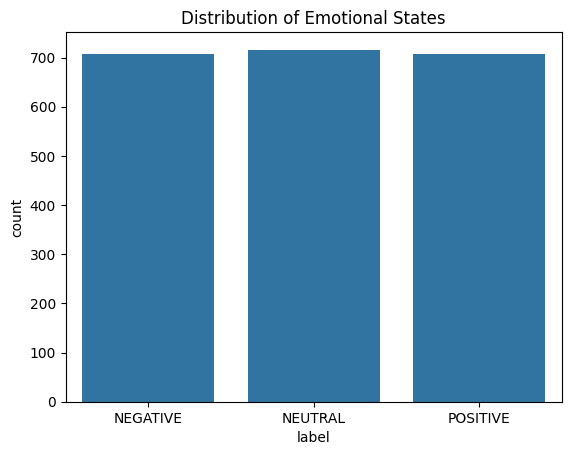

# Visualization: Pie Chart of Emotional States


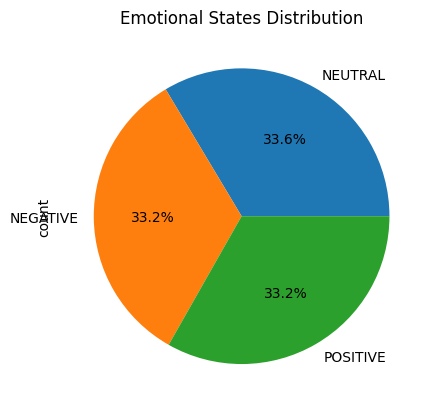

# Visualization: Histogram of mean_0_a (Before Preprocessing)


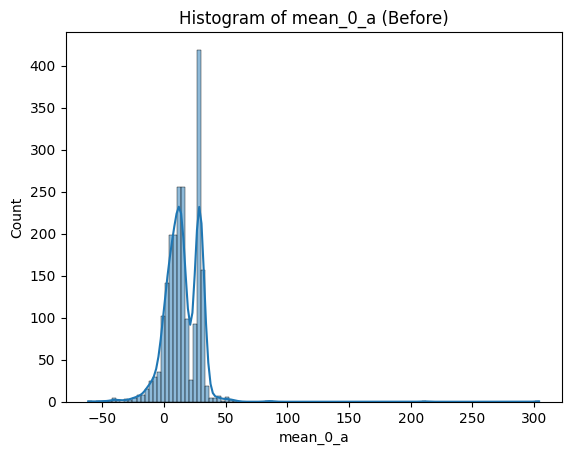

# Visualization: Box Plot of mean_0_a by Emotional State (Before Preprocessing)


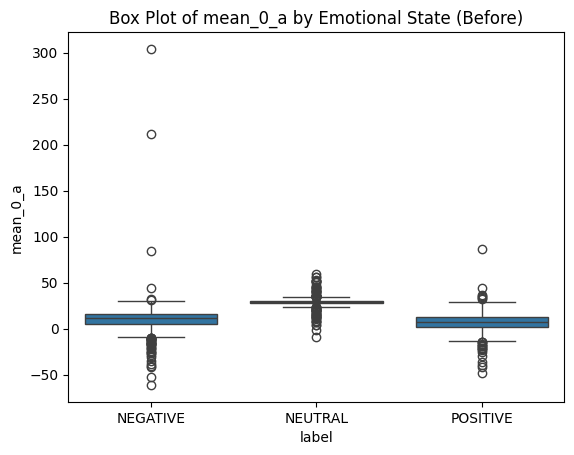

# Visualization: Histogram of mean_b (Before Preprocessing)


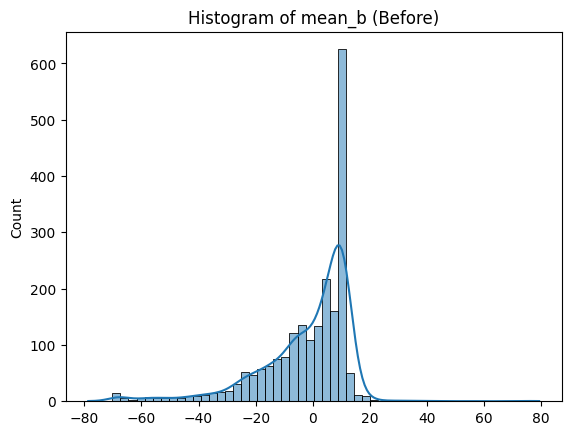

# Visualization: Box Plot of mean_b by Emotional State (Before Preprocessing)


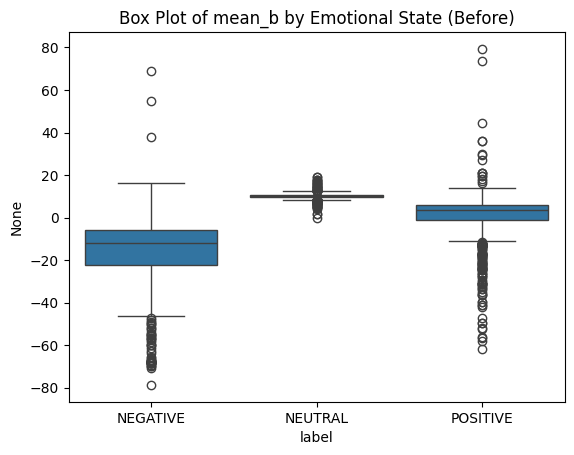

In [ ]:
print("\n# Visualization: Distribution of Emotional States (Bar Chart)")
sns.countplot(x='label', data=data)
plt.title('Distribution of Emotional States')
plt.show()


print("# Visualization: Pie Chart of Emotional States")
data['label'].value_counts().plot.pie(autopct='%1.1f%%', title='Emotional States Distribution')
plt.show()

print("# Visualization: Histogram of mean_0_a (Before Preprocessing)")
sns.histplot(data['mean_0_a'], kde=True)
plt.title('Histogram of mean_0_a (Before)')
plt.show()

print("# Visualization: Box Plot of mean_0_a by Emotional State (Before Preprocessing)")
sns.boxplot(x='label', y='mean_0_a', data=data)
plt.title('Box Plot of mean_0_a by Emotional State (Before)')
plt.show()


fft_cols_b = [col for col in data.columns if 'fft' in col and col.endswith('_b')]
mean_b_cols = [col for col in data.columns if 'mean' in col and col.endswith('_b')]
mean_b = data[mean_b_cols].mean(axis=1)
print("# Visualization: Histogram of mean_b (Before Preprocessing)")
sns.histplot(mean_b, kde=True)
plt.title('Histogram of mean_b (Before)')
plt.show()

print("# Visualization: Box Plot of mean_b by Emotional State (Before Preprocessing)")
sns.boxplot(x='label', y=mean_b, data=data.assign(mean_b=mean_b))
plt.title('Box Plot of mean_b by Emotional State (Before)')
plt.show()

In [ ]:
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
# Independent t-test: Compare mean_0_a between NEGATIVE and POSITIVE
neg_data = data[data['label'] == 'NEGATIVE']['mean_0_a'].dropna()
pos_data = data[data['label'] == 'POSITIVE']['mean_0_a'].dropna()
t_stat, p_val = ttest_ind(neg_data, pos_data)
print(f"t-test (NEGATIVE vs POSITIVE for mean_0_a): t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

# ANOVA: Compare alpha_power_a across all emotional states (after initial feature extraction preview)
data_preprocessed = data.copy()
fft_cols_a = [col for col in data_preprocessed.columns if 'fft' in col and col.endswith('_a')]
for col in fft_cols_a:
    data_preprocessed[col] = pd.to_numeric(data_preprocessed[col], errors='coerce')
data_preprocessed = data_preprocessed.dropna(subset=fft_cols_a)
n_bins = len(fft_cols_a)
freq_step = 128.0 / n_bins
bands = {'alpha': (8, 12)}
def compute_band_power(row, cols, band_range):
    freq_start = int(band_range[0] / freq_step)
    freq_end = int(band_range[1] / freq_step)
    return row[cols[freq_start:freq_end]].sum()
data_preprocessed['alpha_power_a'] = data_preprocessed.apply(
    lambda row: compute_band_power(row, fft_cols_a, bands['alpha']), axis=1
)
f_stat, p_val = f_oneway(
    data_preprocessed[data_preprocessed['label'] == 'NEGATIVE']['alpha_power_a'].dropna(),
    data_preprocessed[data_preprocessed['label'] == 'NEUTRAL']['alpha_power_a'].dropna(),
    data_preprocessed[data_preprocessed['label'] == 'POSITIVE']['alpha_power_a'].dropna()
)
print(f"ANOVA (alpha_power_a across all states): F-statistic = {f_stat:.3f}, p-value = {p_val:.3f}")


# Chi-Square Test: Discretize alpha_power_a and test independence with label
data_preprocessed['alpha_power_a_bin'] = pd.qcut(data_preprocessed['alpha_power_a'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
contingency_table = pd.crosstab(data_preprocessed['alpha_power_a_bin'], data_preprocessed['label'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square (alpha_power_a_bin vs label): chi2 = {chi2_stat:.3f}, p-value = {p_val:.3f}")



#Note : The Values printed here are rounded of to 3 decimal places for better readability.

t-test (NEGATIVE vs POSITIVE for mean_0_a): t-statistic = 4.678, p-value = 0.000
ANOVA (alpha_power_a across all states): F-statistic = 84.780, p-value = 0.000
Chi-Square (alpha_power_a_bin vs label): chi2 = 701.574, p-value = 0.000


#Step 2: Data Preprocessing and Feature Extraction

## Data Cleaning: Handle Outliers using IQR Method

In [ ]:
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data_preprocessed = cap_outliers(data.copy(), numerical_cols)

## Visualization

# Visualization: Box Plot of mean_0_a (Before and After Outlier Capping)


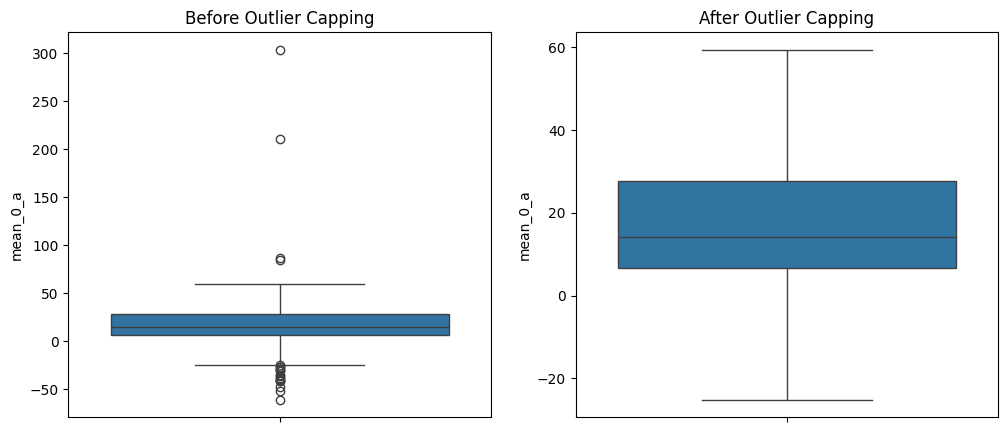

# Visualization: Box Plot of mean_b (Before and After Outlier Capping)


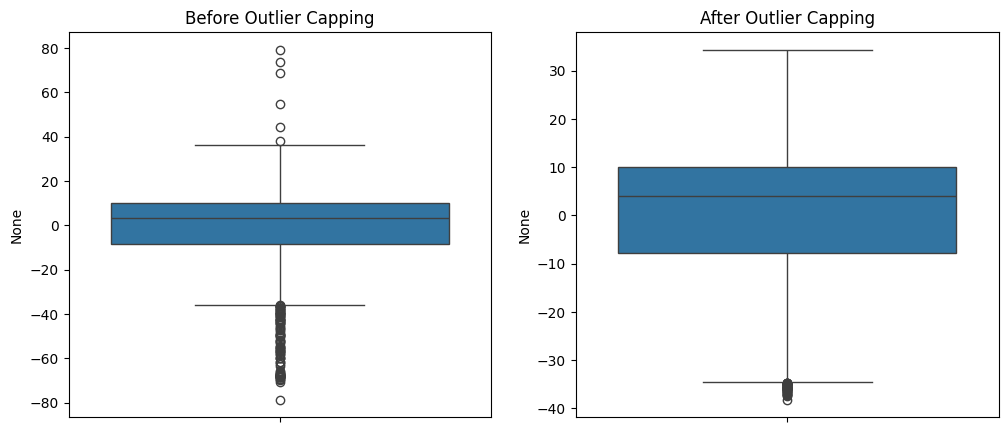

In [ ]:

print("# Visualization: Box Plot of mean_0_a (Before and After Outlier Capping)")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=data['mean_0_a'], ax=ax1)
ax1.set_title('Before Outlier Capping')
sns.boxplot(y=data_preprocessed['mean_0_a'], ax=ax2)
ax2.set_title('After Outlier Capping')
plt.show()

print("# Visualization: Box Plot of mean_b (Before and After Outlier Capping)")
mean_b_pre = data[mean_b_cols].mean(axis=1)
mean_b_post = data_preprocessed[mean_b_cols].mean(axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=mean_b_pre, ax=ax1)
ax1.set_title('Before Outlier Capping')
sns.boxplot(y=mean_b_post, ax=ax2)
ax2.set_title('After Outlier Capping')
plt.show()

## Feature Extraction

In [ ]:
print("# Feature Extraction: Creating Frequency Band Power Features")
fft_cols_a = [col for col in data.columns if 'fft' in col and col.endswith('_a')]
fft_cols_b = [col for col in data.columns if 'fft' in col and col.endswith('_b')]
fft_cols = fft_cols_a + fft_cols_b
for col in fft_cols:
    data_preprocessed[col] = pd.to_numeric(data_preprocessed[col], errors='coerce')
data_preprocessed = data_preprocessed.dropna(subset=fft_cols)


n_bins = len(fft_cols_a)
freq_step = 128.0 / n_bins
bands = {
    'delta': (0, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 100)
}

def compute_band_power(row, cols, band_range):
    freq_start = int(band_range[0] / freq_step)
    freq_end = int(band_range[1] / freq_step)
    return row[cols[freq_start:freq_end]].sum()

for band, (low, high) in bands.items():
    data_preprocessed[f'{band}_power_a'] = data_preprocessed.apply(
        lambda row: compute_band_power(row, fft_cols_a, (low, high)), axis=1
    )
    data_preprocessed[f'{band}_power_b'] = data_preprocessed.apply(
        lambda row: compute_band_power(row, fft_cols_b, (low, high)), axis=1
    )

# Feature Extraction: Creating Frequency Band Power Features


##Data Representation After Feature Extraction

# Data Representation After Feature Extraction
# Visualization: Box Plot of Alpha Power (After Feature Creation)


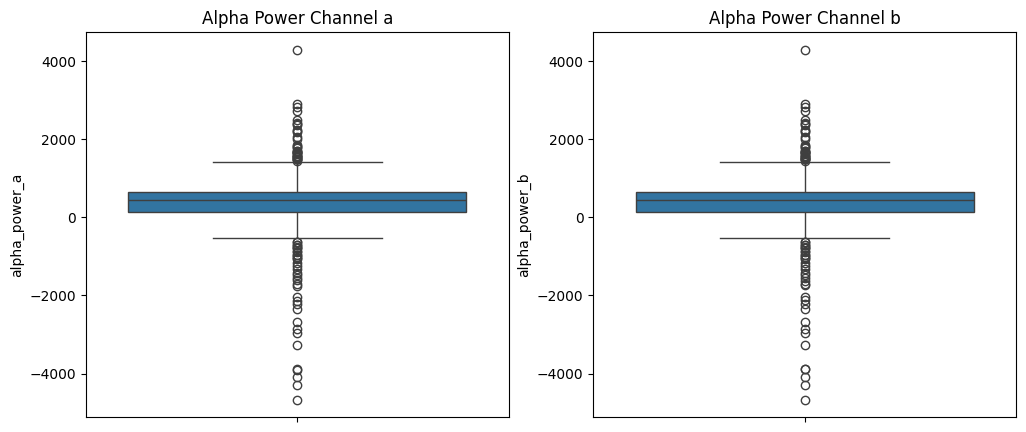

# Visualization: Violin Plot of All Band Powers


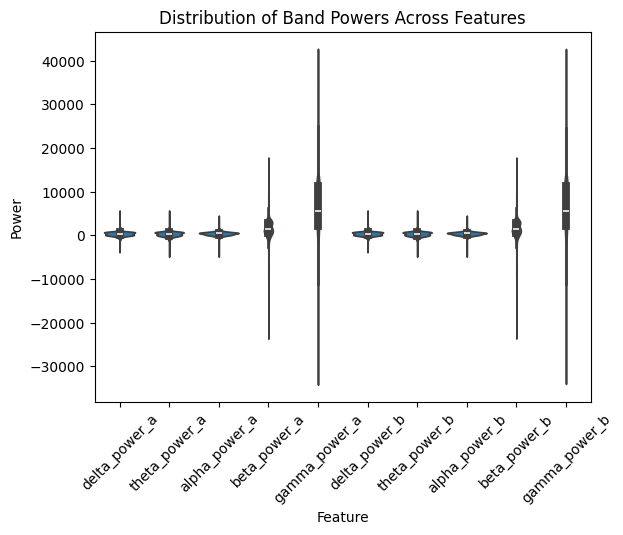

# Visualization: Heatmap of Correlation Matrix


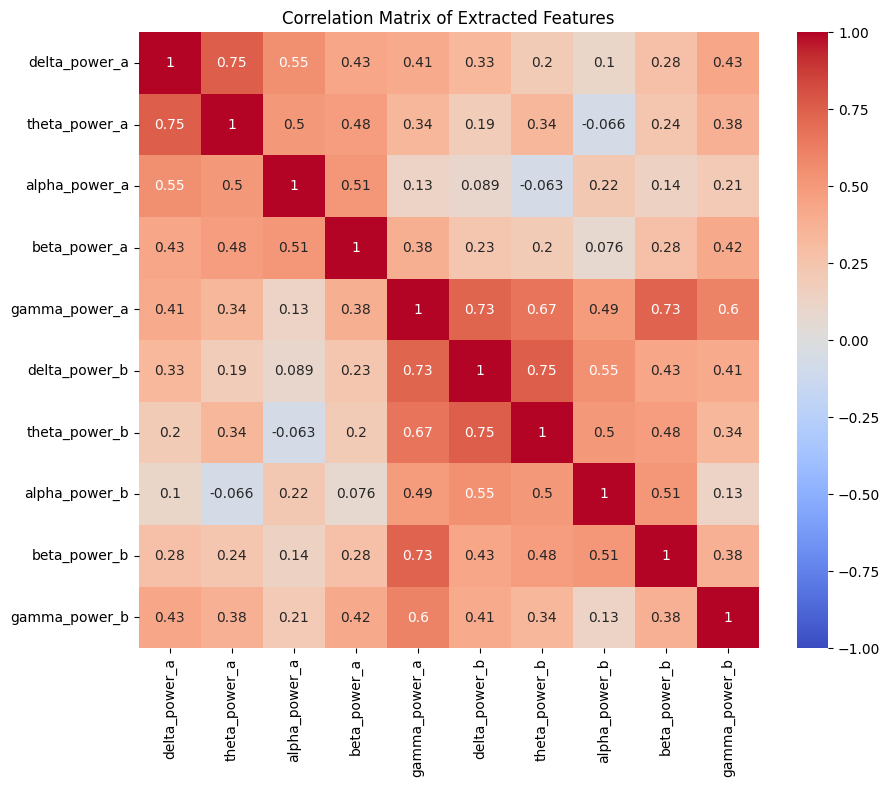

# Visualization: Line Plot of Average Band Power by Emotional State


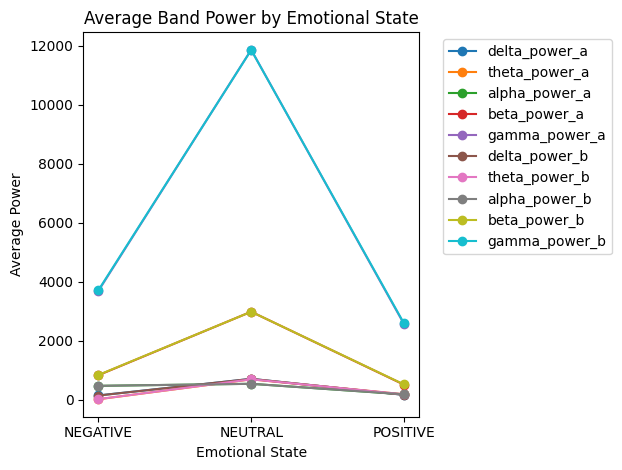

In [ ]:
print("# Data Representation After Feature Extraction")
print("# Visualization: Box Plot of Alpha Power (After Feature Creation)")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=data_preprocessed['alpha_power_a'], ax=ax1)
ax1.set_title('Alpha Power Channel a')
sns.boxplot(y=data_preprocessed['alpha_power_b'], ax=ax2)
ax2.set_title('Alpha Power Channel b')
plt.show()

print("# Visualization: Violin Plot of All Band Powers")
band_power_cols = [f'{band}_power_a' for band in bands] + [f'{band}_power_b' for band in bands]
melted_data = data_preprocessed.melt(value_vars=band_power_cols, var_name='Feature', value_name='Power')
sns.violinplot(x='Feature', y='Power', data=melted_data)
plt.xticks(rotation=45)
plt.title('Distribution of Band Powers Across Features')
plt.show()

print("# Visualization: Heatmap of Correlation Matrix")
corr_matrix = data_preprocessed[band_power_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Extracted Features')
plt.show()

print("# Visualization: Line Plot of Average Band Power by Emotional State")
band_means = data_preprocessed.groupby('label')[band_power_cols].mean().reset_index()
for col in band_power_cols:
    plt.plot(band_means['label'], band_means[col], marker='o', label=col)
plt.xticks(ticks=[0, 1, 2], labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
plt.title('Average Band Power by Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Power')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Map Labels to Numerical Values
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
data_preprocessed['label'] = data_preprocessed['label'].map(label_mapping)

# Split Data
X = data_preprocessed.drop('label', axis=1)
y = data_preprocessed['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: RL-Based Feature Selection

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RL Hyperparameters
n_episodes = 50
max_steps = 20
learning_rate = 0.1
discount_factor = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
n_features = X_scaled.shape[1]
feature_indices = list(range(n_features))


q_table = {}

def get_q_value(state):
    state_tuple = tuple(state)
    if state_tuple not in q_table:
        q_table[state_tuple] = np.zeros(2)
    return q_table[state_tuple]

# Reward Function: Accuracy of Logistic Regression
def get_reward(selected_features):
    if not selected_features:
        return -1
    X_selected = X_scaled[:, selected_features]
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_selected, y_train, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000, solver='saga')
    model.fit(X_train_sub, y_train_sub)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

# RL Feature Selection Loop
selected_features = set()
for episode in range(n_episodes):
    current_state = list(selected_features)
    for step in range(max_steps):
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 1)
        else:
            action = np.argmax(get_q_value(current_state))

        if action == 1 and current_state:
            feature_to_remove = random.choice(list(current_state))
            next_state = current_state.copy()
            next_state.remove(feature_to_remove)
        else:
            available_features = [f for f in feature_indices if f not in current_state]
            if available_features:
                feature_to_add = random.choice(available_features)
                next_state = current_state + [feature_to_add]
            else:
                next_state = current_state

        reward = get_reward(next_state)
        old_q_value = get_q_value(current_state)[action]
        next_q_value = np.max(get_q_value(next_state))
        new_q_value = old_q_value + learning_rate * (reward + discount_factor * next_q_value - old_q_value)
        q_table[tuple(current_state)][action] = new_q_value
        current_state = next_state

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{n_episodes}, Selected Features: {len(current_state)}")

# Apply Selected Features
final_selected_features = current_state
X_train_selected = X_scaled[:, final_selected_features]
X_test_selected = X_test_scaled[:, final_selected_features]

Episode 10/50, Selected Features: 6
Episode 20/50, Selected Features: 0
Episode 30/50, Selected Features: 12
Episode 40/50, Selected Features: 12
Episode 50/50, Selected Features: 4


# Step 4: Feature Transformation

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Step 5: Feature Reduction with Autoencoder

In [ ]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 50
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)
encoder = Model(input_layer, encoded)
X_train_latent = encoder.predict(X_train_scaled)
X_test_latent = encoder.predict(X_test_scaled)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


# Step 6: Model Implementations

In [ ]:
print("# Model Implementation: Classification with Neural Network")
inputs = tf.keras.Input(shape=(encoding_dim,))
dense1 = tf.keras.layers.Dense(128, activation='relu')(inputs)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
outputs = tf.keras.layers.Dense(3, activation='softmax')(dense2)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_latent, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

print("# Additional Model: Random Forest Classifier")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_latent, y_train)

# Model Implementation: Classification with Neural Network
# Additional Model: Random Forest Classifier


RandomForestClassifier(random_state=42)

# Step 7: Results and Comparisons

##Evaluate

In [ ]:
# Evaluate Neural Network
nn_pred = np.argmax(model.predict(X_test_latent), axis=1)
nn_acc = accuracy_score(y_test, nn_pred)
print(f"\n# Results: Neural Network Accuracy: {nn_acc:.3f}")

# Evaluate Random Forest
rf_pred = rf_model.predict(X_test_latent)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_acc:.3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

# Results: Neural Network Accuracy: 0.867
Random Forest Accuracy: 0.855


## Confusion Matrix

# Visualization: Confusion Matrix (Heatmap) for Neural Network


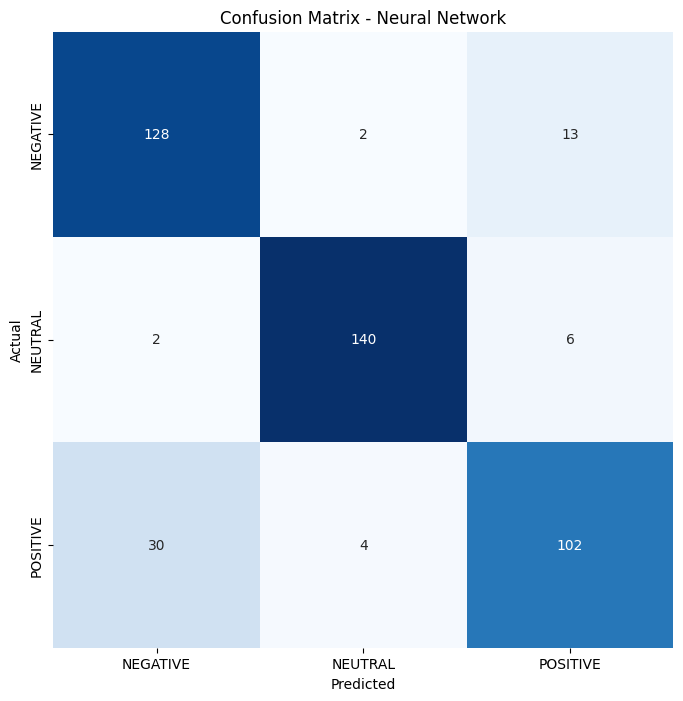

# Visualization: Confusion Matrix (Heatmap) for Random Forest


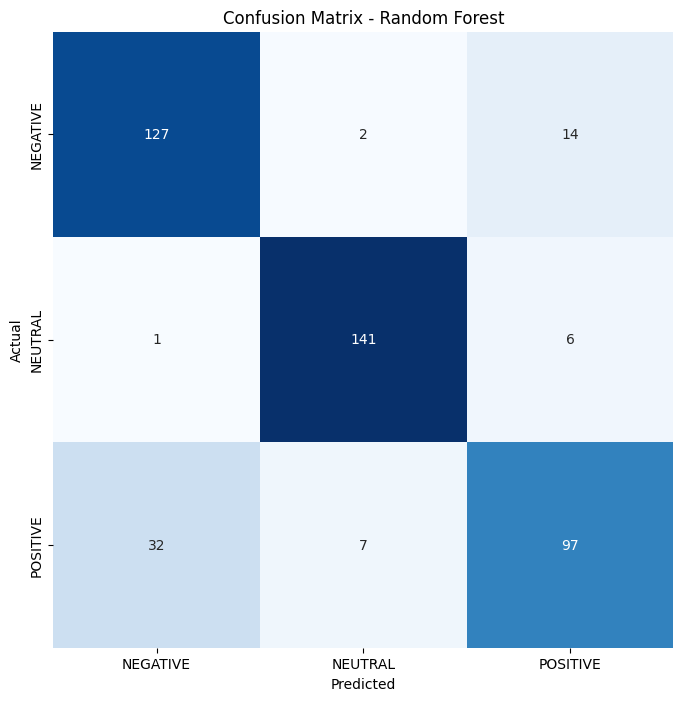

In [ ]:

print("# Visualization: Confusion Matrix (Heatmap) for Neural Network")
cm_nn = confusion_matrix(y_test, nn_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

print("# Visualization: Confusion Matrix (Heatmap) for Random Forest")
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


##Classification Report


# Results: Classification Report for Neural Network
Classification Report (Neural Network):
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.80      0.90      0.84       143
     NEUTRAL       0.96      0.95      0.95       148
    POSITIVE       0.84      0.75      0.79       136

    accuracy                           0.87       427
   macro avg       0.87      0.86      0.86       427
weighted avg       0.87      0.87      0.87       427

# Results: Classification Report for Random Forest
Classification Report (Random Forest):
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.79      0.89      0.84       143
     NEUTRAL       0.94      0.95      0.95       148
    POSITIVE       0.83      0.71      0.77       136

    accuracy                           0.85       427
   macro avg       0.85      0.85      0.85       427
weighted avg       0.86      0.85      0.85       427

# Visual

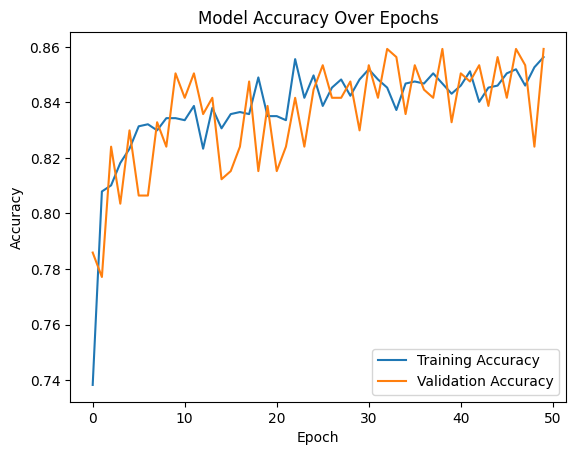

In [ ]:
print("# Results: Classification Report for Neural Network")
clr_nn = classification_report(y_test, nn_pred, target_names=label_mapping.keys())
print("Classification Report (Neural Network):\n----------------------\n", clr_nn)

print("# Results: Classification Report for Random Forest")
clr_rf = classification_report(y_test, rf_pred, target_names=label_mapping.keys())
print("Classification Report (Random Forest):\n----------------------\n", clr_rf)

print("# Visualization: Training and Validation Accuracy (Line Chart)")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##McNemar's Test for model comparison

In [ ]:
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test
correct_nn = nn_pred == y_test_array
correct_rf = rf_pred == y_test_array
table = [[sum(correct_nn & correct_rf), sum(correct_nn & ~correct_rf)],
         [sum(~correct_nn & correct_rf), sum(~correct_nn & ~correct_rf)]]
result = mcnemar(table, exact=False)
print("McNemar's test statistic:", result.statistic)
print("p-value:", result.pvalue)

if result.pvalue < 0.05:
    if nn_acc > rf_acc:
        print("Neural Network is significantly better than Random Forest.")
    else:
        print("Random Forest is significantly better than Neural Network.")
else:
    print("No significant difference between the two models.")

McNemar's test statistic: 0.64
p-value: 0.4237107971667936
No significant difference between the two models.


In [ ]:
import joblib
import os
from tensorflow.keras.models import save_model

# Create a directory to save the models
os.makedirs('models', exist_ok=True)

# Save the models and objects
joblib.dump(scaler, 'models/scaler.joblib')
joblib.dump(final_selected_features, 'models/final_selected_features.joblib')
encoder.save('models/encoder_model.h5')
model.save('models/nn_model.h5')
joblib.dump(rf_model, 'models/rf_model.joblib')

print("Models and objects saved successfully in the 'models' directory.")